<p style="background-color:firebrick;font-family:newtimeroman;font-size:200%;color:white;text-align:center;border-radius:60px 20px;"><b>LightGBM Boost Regression</b></p>

**About Dataset**

- **Car_Name**: The name or model of the car.
- **Year**: The year of manufacture of the car.
- **Selling_Price**: The selling price of the car.
- **Present_Price**: The current showroom price of the car.
- **Kms_Driven**: The total kilometers driven by the car up to the point of sale.
- **Fuel_Type**: This column would contain categories such as:
  - **Petrol**: Cars that run on petrol fuel.
  - **Diesel**: Cars that use diesel fuel.
  - **CNG**: Cars that are powered by compressed natural gas.

- **Seller_Type**: This column would indicate the type of seller offering the car, which could be:
  - **Dealer**: A business that sells cars as part of its commercial operations.
  - **Individual**: A private individual selling a personal vehicle.

- **Transmission**: This refers to the gearbox system of the car, with common types being:
  - **Manual**: Cars where the driver manually shifts gears.
  - **Automatic**: Cars where the gear shifting process is automated.

- **Owner**: This would typically be a numeric column indicating the number of previous owners of the car, but if it is categorical, it might have entries such as:
  - **First Owner**: Indicates the car is being sold by its original owner.
  - **Second Owner**: Indicates the car has had one previous owner before the current seller.
  - **Third Owner**, and so on.
  
This data set is for estimating the selling price of a car based on its features.

# <font color='firebrick'> <b>Importing Libraries</b><font color='black'>  

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

plt.rcParams["figure.figsize"] = (9,5)

import warnings
warnings.filterwarnings('ignore')

# <font color='firebrick'> <b>Loading The Dataset</b><font color='black'>  

In [86]:
df0 = pd.read_csv("car_dataset.csv")
df = df0.copy()

In [87]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


# <font color='firebrick'> <b>Understanding Data & EDA</b><font color='black'>  

In [89]:
df.shape

(301, 9)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [91]:
df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [92]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,301.0,2013.627907,2.891554,2003.00,2012.0,2014.0,2016.0,2018.0
Selling_Price,301.0,4.661296,5.082812,0.10,0.9,3.6,6.0,35.0
Present_Price,301.0,7.628472,8.644115,0.32,1.2,6.4,9.9,92.6
Kms_Driven,301.0,36947.205980,38886.883882,500.00,15000.0,32000.0,48767.0,500000.0
Owner,301.0,0.043189,0.247915,0.00,0.0,0.0,0.0,3.0


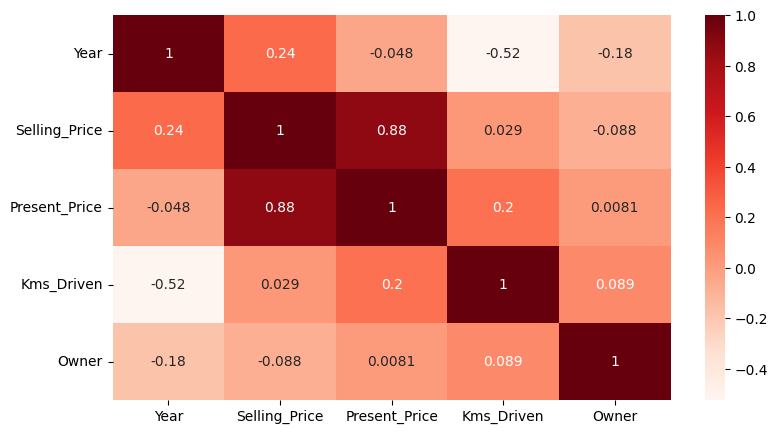

In [93]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Reds")
plt.show()

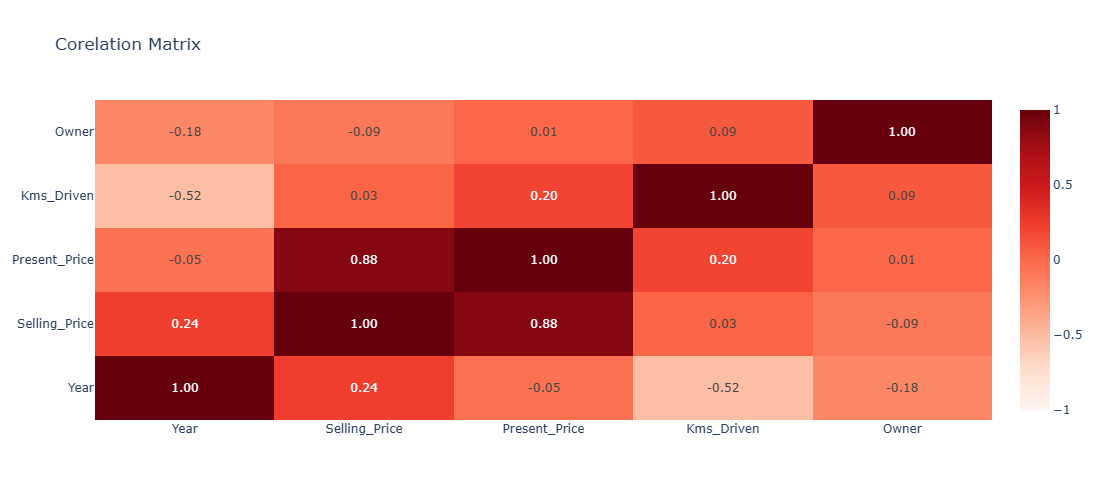

In [94]:
# another correlation matrix

import plotly.graph_objects as go

corr_matrix = df.select_dtypes(include='number').corr()
heatmap = go.Heatmap(
    z=corr_matrix.values, x=corr_matrix.columns, y=corr_matrix.index,
    colorscale='Reds', zmin=-1, zmax=1, text=corr_matrix.values,
    texttemplate="%{text:.2f}", hoverinfo="none"
)

fig = go.Figure(data=[heatmap], layout=go.Layout(
    title='Corelation Matrix', width=700, height=500))
fig.show()

In [95]:
df["Vehicle_Age"] = 2024 - df.Year

# Converting the vehicle production year in the data set to "age" feature.

In [96]:
def unique_values(df, columns):
    """Prints unique values and their counts for specific columns in the DataFrame."""

    for column_name in columns:
        print(f"Column: {column_name}\n{'-'*30}")
        unique_vals = df[column_name].unique()
        value_counts = df[column_name].value_counts()
        print(f"Unique Values ({len(unique_vals)}): {unique_vals}\n")
        print(f"Value Counts:\n{value_counts}\n{'='*40}\n")

In [97]:
cat_features = df.select_dtypes(include='object').columns
unique_values(df, cat_features)

# Seeing how many unique observations categorical features consist of.
# The number of unique categorical observations of car_name is very high compared to the total number of observations in the data set.

Column: Car_Name
------------------------------
Unique Values (98): ['ritz' 'sx4' 'ciaz' 'wagon r' 'swift' 'vitara brezza' 's cross'
 'alto 800' 'ertiga' 'dzire' 'alto k10' 'ignis' '800' 'baleno' 'omni'
 'fortuner' 'innova' 'corolla altis' 'etios cross' 'etios g' 'etios liva'
 'corolla' 'etios gd' 'camry' 'land cruiser' 'Royal Enfield Thunder 500'
 'UM Renegade Mojave' 'KTM RC200' 'Bajaj Dominar 400'
 'Royal Enfield Classic 350' 'KTM RC390' 'Hyosung GT250R'
 'Royal Enfield Thunder 350' 'KTM 390 Duke ' 'Mahindra Mojo XT300'
 'Bajaj Pulsar RS200' 'Royal Enfield Bullet 350'
 'Royal Enfield Classic 500' 'Bajaj Avenger 220' 'Bajaj Avenger 150'
 'Honda CB Hornet 160R' 'Yamaha FZ S V 2.0' 'Yamaha FZ 16'
 'TVS Apache RTR 160' 'Bajaj Pulsar 150' 'Honda CBR 150' 'Hero Extreme'
 'Bajaj Avenger 220 dtsi' 'Bajaj Avenger 150 street' 'Yamaha FZ  v 2.0'
 'Bajaj Pulsar  NS 200' 'Bajaj Pulsar 220 F' 'TVS Apache RTR 180'
 'Hero Passion X pro' 'Bajaj Pulsar NS 200' 'Yamaha Fazer '
 'Honda Activa 4G' 'TVS 

In [98]:
df.drop(columns=["Car_Name", "Year"], inplace=True)

In [99]:
df.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Vehicle_Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,10
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,11
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,7
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,13
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,10


In [100]:
df.Transmission.unique()

array(['Manual', 'Automatic'], dtype=object)

<Figure size 1200x600 with 0 Axes>

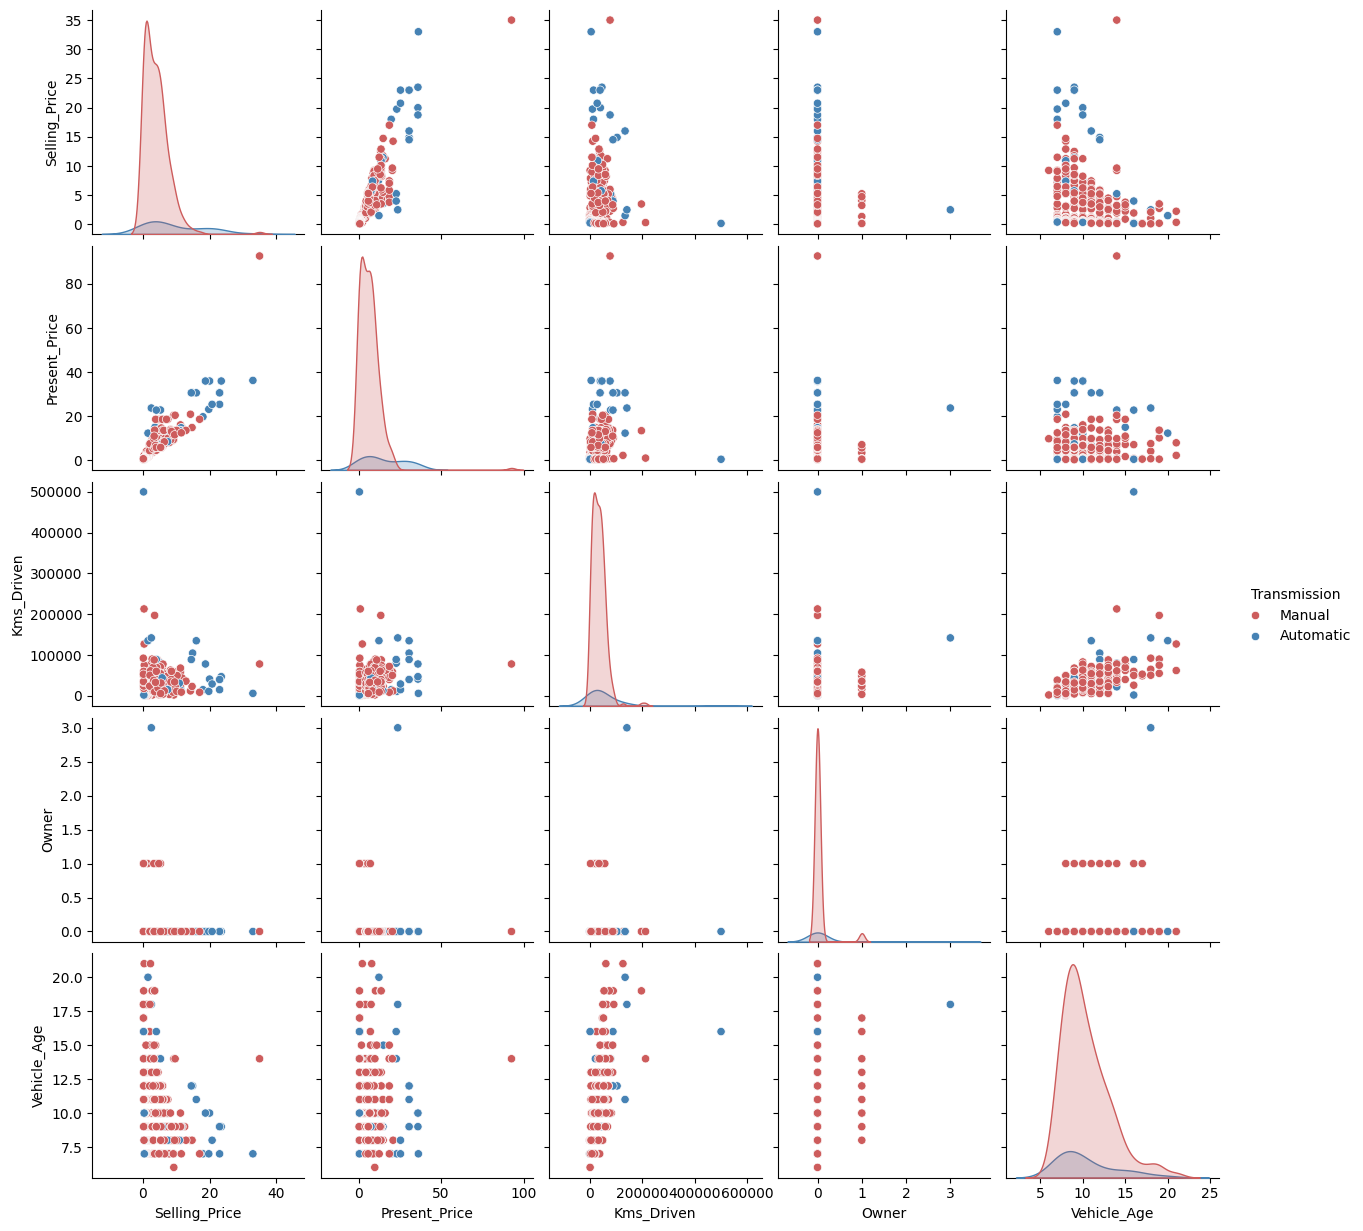

In [101]:
plt.figure(figsize=(12, 6))
sns.pairplot(df, hue="Transmission", palette=["indianred", "steelblue"])
plt.show()

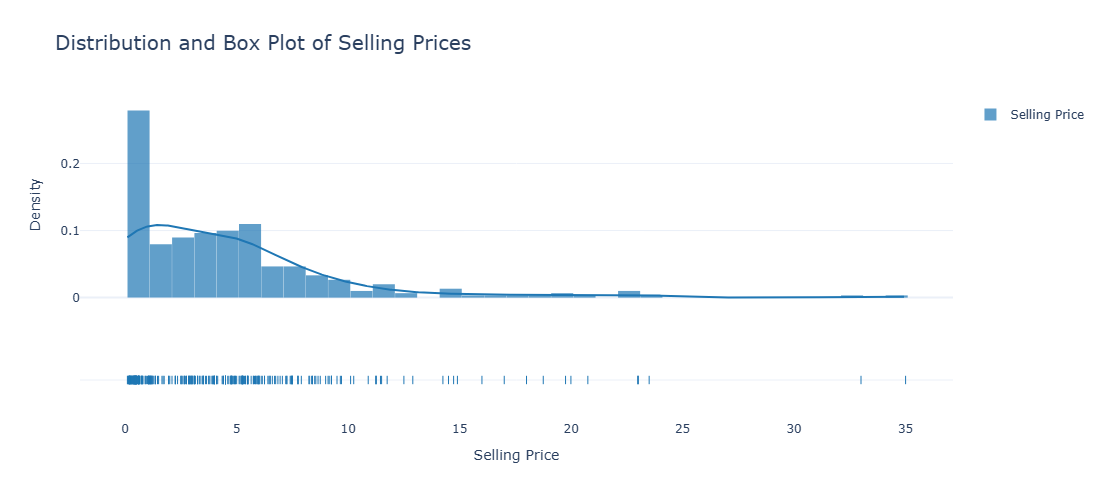

In [102]:
import plotly.figure_factory as ff

fig = ff.create_distplot([df['Selling_Price']], ['Selling Price'],
                         show_hist=True,
                         show_rug=True)

fig.update_layout(
    title_text='Distribution and Box Plot of Selling Prices',
    title_font_size=20,
    xaxis_title_text='Selling Price',
    yaxis_title_text='Density',
    template='plotly_white',
    width=1000,
    height=500,
    bargap=0.01,
)

fig.show()

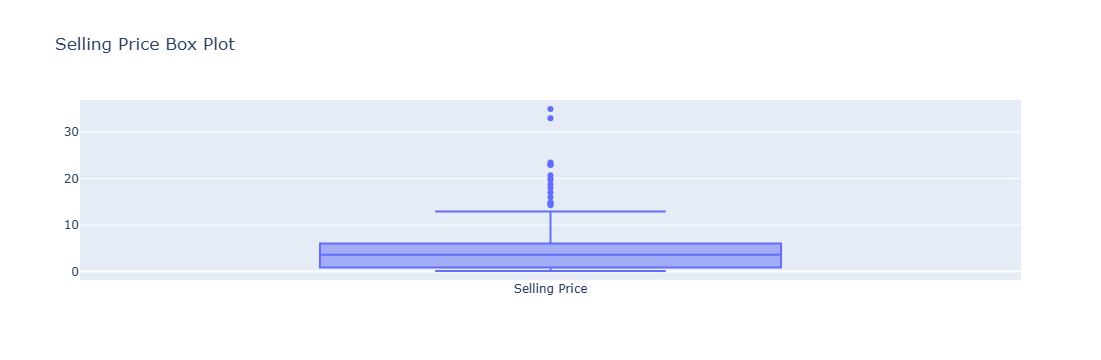

In [103]:
import plotly.graph_objs as go

box_plot = go.Box(y=df['Selling_Price'], name='Selling Price')

fig = go.Figure(data=[box_plot])
fig.update_layout(title='Selling Price Box Plot')
fig.show()

# <font color='firebrick'> <b>Modeling</b><font color='black'>  

## <font color='indianred'> <b>Train | Test Split</b><font color='black'>  

In [106]:
df2 = df[df.Selling_Price < 10]
df2.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Vehicle_Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,10
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,11
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,7
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,13
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,10


In [107]:
X=df2.drop("Selling_Price", axis=1)
y=df2.Selling_Price

In [108]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=101)

print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (218, 7)
Train target shape   :  (218,)
Test features shape  :  (55, 7)
Test target shape    :  (55,)


In [109]:
cat_features = X.select_dtypes("object").columns
cat_features 

Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object')

In [110]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat_features), remainder='passthrough')

In [111]:
def train_val(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

## <font color='indianred'> <b>LightGBM Regressor</b><font color='black'>  

**Overview**
LightGBM is a light and fast gradient boosting framework developed by Microsoft. It stands out for its fast training times and low memory consumption on large datasets. It is also known for its ability to handle categorical features directly.

**Key Features**
- **Speed and Efficiency**: Fast training on large datasets and low memory usage.
- **Direct Handling of Categorical Features**: Can process categorical data without the need for feature engineering.
- **Flexibility**: Customizable with various loss functions and hyperparameters.

**Important Parameters**

**num_leaves**: The maximum number of leaves in each tree. Controls the complexity of the model.

**learning_rate**: Determines how quickly the model learns at each iteration. A lower value generally results in better generalization performance.

**n_estimators**: The total number of trees to be created. More trees typically lead to better performance.

**max_depth**: The maximum depth of the trees. Deeper trees can make the model more complex.

**min_data_in_leaf**: The minimum number of data points required in a leaf. Helps prevent overfitting.

**bagging_fraction**: The fraction of data samples to be used in each iteration. Reduces overfitting and increases model robustness.

**feature_fraction**: The fraction of features to be used in each iteration. Allows the model to train on different combinations of features.

**lambda_l1, lambda_l2**: L1 and L2 regularization terms, respectively. Reduce model complexity and prevent overfitting.

**objective**: The target function to optimize. Examples: regression, regression_l1, huber, fair.

**boosting_type**: The type of boosting to use. Options: gbdt (traditional Gradient Boosting Decision Tree), dart (Dropouts meet Multiple Additive Regression Trees).

**Application Notes**
- LightGBM is faster than XGBoost and other gradient boosting frameworks, especially on large datasets and high-dimensional data.
- Proper parameter tuning can signifiantly impact model performance.


In [114]:
operations = [("OrdinalEncoder", column_trans), ("LGBM_model", LGBMRegressor(random_state=101, objective='regression'))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 218, number of used features: 6
[LightGBM] [Info] Start training from score 3.390826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                ('LGBM_model',
                 LGBMRegressor(objective='regression', random_state=101))])

In [115]:
train_val(pipe_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.970720,0.971920
mae,0.292468,0.348476
mse,0.201981,0.229899
rmse,0.449423,0.479478


## <font color='indianred'> <b>Cross Validation</b><font color='black'>  

In [117]:
operations = [("OrdinalEncoder", column_trans),
              ("LGBM_model",
               LGBMRegressor(random_state=101, objective='regression'))]

model = Pipeline(steps=operations)
scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=[
                            'r2', 'neg_mean_absolute_error',
                            'neg_mean_squared_error',
                            'neg_root_mean_squared_error'
                        ],
                        cv=5,
                        return_train_score=True)

pd.DataFrame(scores).mean()[2:]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 174, number of used features: 5
[LightGBM] [Info] Start training from score 3.302989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

test_r2                              0.903042
train_r2                             0.957925
test_neg_mean_absolute_error        -0.504097
train_neg_mean_absolute_error       -0.332995
test_neg_mean_squared_error         -0.639389
train_neg_mean_squared_error        -0.289303
test_neg_root_mean_squared_error    -0.781373
train_neg_root_mean_squared_error   -0.535938
dtype: float64

## <font color='indianred'> <b>GridSearchCV</b><font color='black'>  

**Hyperparameters**

* **boosting_type**: Specifies the type of boosting used. 'gbdt' (gradient boosting decision tree) is usually the default and most commonly used type.

* **num_leaves**: Specifies the maximum number of leaves in a tree. The higher this value, the more complex the model becomes, but it can also lead to overfitting.

* **max_depth**: Specifies the maximum depth of the tree. -1 means unlimited depth. As depth increases, the model becomes more complex.

* **learning_rate**: Determines the learning rate. A lower learning rate may result in slower learning but better generalization, though it requires more iterations.

* **n_estimators**: Specifies the number of trees to be used for training. More trees generally lead to better performance, but it increases computation time and can lead to overfitting.

* **subsample_for_bin**: Specifies the number of samples to be used for creating histograms. Larger values provide more accurate but slower computation.

* **objective**: Specifies the target function to optimize.

* **class_weight**: Specifies the class weights, typically used for imbalanced datasets.

* **min_split_gain**: The minimum gain required to split a node. Larger values can help prevent overfitting.

* **min_child_weight**: The minimum weight for a leaf. Larger values make the model more conservative.

* **min_child_samples**: The minimum number of samples required in a leaf.

* **subsample**: The fraction of samples to be used in each iteration. Helps prevent overfitting.

* **subsample_freq**: Specifies the frequency of subsampling.

* **colsample_bytree**: The fraction of features to be used in each iteration.

* **reg_alpha**: L1 regularization term.

* **reg_lambda**: L2 regularization term.

* **random_state**: Seed value for randomness.

* **n_jobs**: The number of threads to run in parallel.

* **importance_type**: Method used to determine feature importance.

---

- **LightGBM:**
  - LGBMClassifier and LGBMRegressor loss functions are also set via the objective parameter. For classification, options include binary, multiclass; for regression, options includeregression, huber, quantile, and others.


In [120]:
param_grid = {
    'LGBM_model__learning_rate': [0.01, 0.05, 0.1],
    'LGBM_model__n_estimators': [100, 200, 500],
    'LGBM_model__max_depth': [3, 5],
    "LGBM_model__num_leaves": [8, 32, 256],  # Values ​​suitable for 2^max_depth, this means take the maxdepth power of two.
    'LGBM_model__subsample': [0.8, 1.0],
    'LGBM_model__colsample_bytree': [0.8, 0.9, 1.0]
}

**Importance of num_leaves and max_depth Parameters in LightGBM**

In LightGBM, the num_leaves parameter defines the maximum number of leaves in each tree, which has a direct impact on the model's complexity. The max_depth parameter specifies the maximum depth of the tree. However, these two parameters should be in harmony with each other.

**Tuning the num_leaves Parameter**
- The num_leaves parameter is typically set to a value smaller than 2^max_depth. This is based on the idea that two branches can grow at each level.
- If max_depth is set and num_leaves is not adjusted (or set to a very large value), LightGBM may issue a warning that it could lead to a deviation from the expected performance of the model.

**Ensuring Harmony**
- Ideally, the num_leaves value should be less than or equal to 2^max_depth. However, this may not always be ideal, as creating very deep trees can lead to overfitting.
- Therefore, it is important to carefully adjust the num_leaves parameter and find a suitable value for the model. This should be considered during the hyperparameter optimization process.

**Practical Application**
When tuning your model and performing hyperparameter optimization, keep in mind the harmony between these two parameters. A balanced setting will enhance the model's generalization ability and protect against overfitting.

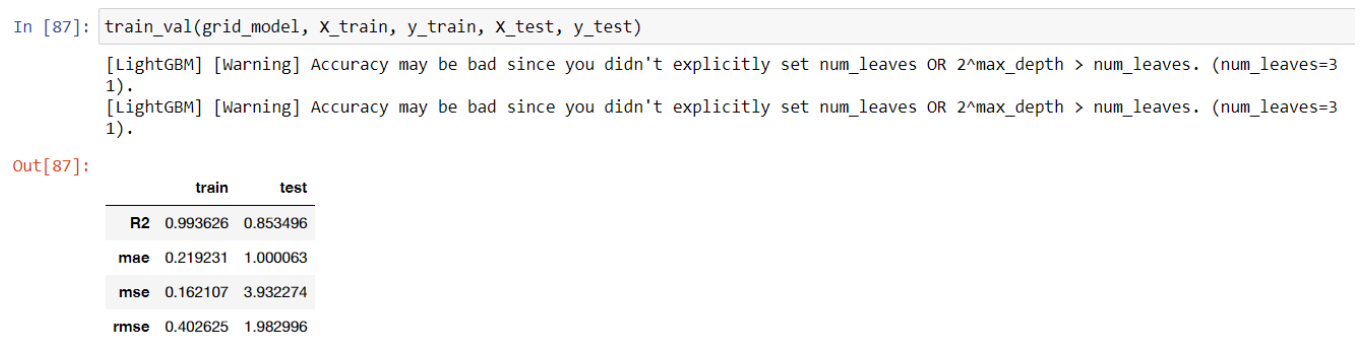

In [122]:
operations = [("OrdinalEncoder", column_trans), ("LGBM_model", LGBMRegressor(random_state=101, objective='regression', verbose=-1))]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=5,
                          n_jobs = -1,
                          return_train_score=True)
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                                       ('LGBM_model',
                                        LGBMRegressor(objective='regression',
                                                      random_state=101,
                                                      verbose=-1))]),
             n_jobs=-1,
             param_grid={'LGBM_model__colsample_bytree': [0.8, 0.9, 1.0],
                         'LGBM_model__learning_rate': [0.01, 0.05, 0.1],
                         'LGBM_model__max_depth': [3, 5],
                         'LGBM_model__n_estimators': [100, 200, 500],
                         'LGBM_model__num_leaves': [8, 32, 256],
                         'LGBM_model__subsample': [0.8, 1.0]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [123]:
grid_model.best_params_

{'LGBM_model__colsample_bytree': 0.8,
 'LGBM_model__learning_rate': 0.1,
 'LGBM_model__max_depth': 3,
 'LGBM_model__n_estimators': 200,
 'LGBM_model__num_leaves': 8,
 'LGBM_model__subsample': 0.8}

In [124]:
grid_model.best_score_

-0.7686273700076095

In [125]:
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.970342,0.973437
mae,0.305457,0.343664
mse,0.204590,0.217481
rmse,0.452316,0.466348


In [126]:
y_pred = grid_model.predict(X_test)
LGBM_R2 = r2_score(y_test, y_pred)
LGBM_mae = mean_absolute_error(y_test, y_pred)
LGBM_mse = mean_squared_error(y_test, y_pred)
LGBM_rmse = mean_squared_error(y_test, y_pred, squared=False)
train_val(grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.970342,0.973437
mae,0.305457,0.343664
mse,0.204590,0.217481
rmse,0.452316,0.466348


## <font color='indianred'> <b>Feature Importance</b><font color='black'>  

In [128]:
operations = [("OrdinalEncoder", column_trans),
              ("LGBM_model",
               LGBMRegressor(random_state=101,
                             objective='regression',
                             colsample_bytree=0.9,
                             learning_rate=0.05,
                             max_depth=3,
                             subsample=0.8,
                             n_estimators=200,
                             verbose=-1))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'))])),
                ('LGBM_model',
                 LGBMRegressor(colsample_bytree=0.9, learning_rate=0.05,
                               max_depth=3, n_estimators=200,
                               objective='regression', random_state=101,
                               subsample=0.8, verbose=-1))])

In [129]:
pipe_model["LGBM_model"].feature_importances_

array([ 39,  22,  22, 305, 204,   0, 200])

In [130]:
features = pipe_model["OrdinalEncoder"].get_feature_names_out()
features

array(['ordinalencoder__Fuel_Type', 'ordinalencoder__Seller_Type',
       'ordinalencoder__Transmission', 'remainder__Present_Price',
       'remainder__Kms_Driven', 'remainder__Owner',
       'remainder__Vehicle_Age'], dtype=object)

In [131]:
new_features = [i.replace("ordinalencoder__","").replace("remainder__", "") for i in features]
new_features

['Fuel_Type',
 'Seller_Type',
 'Transmission',
 'Present_Price',
 'Kms_Driven',
 'Owner',
 'Vehicle_Age']

In [132]:
imp_feats = pd.DataFrame(data=pipe_model["LGBM_model"].feature_importances_, columns=['LGBM_Importance'], index=new_features)
lgbm_imp_feats = imp_feats.sort_values('LGBM_Importance', ascending=False)
lgbm_imp_feats

,LGBM_Importance
Present_Price,305
Kms_Driven,204
Vehicle_Age,200
Fuel_Type,39
Seller_Type,22
Transmission,22
Owner,0


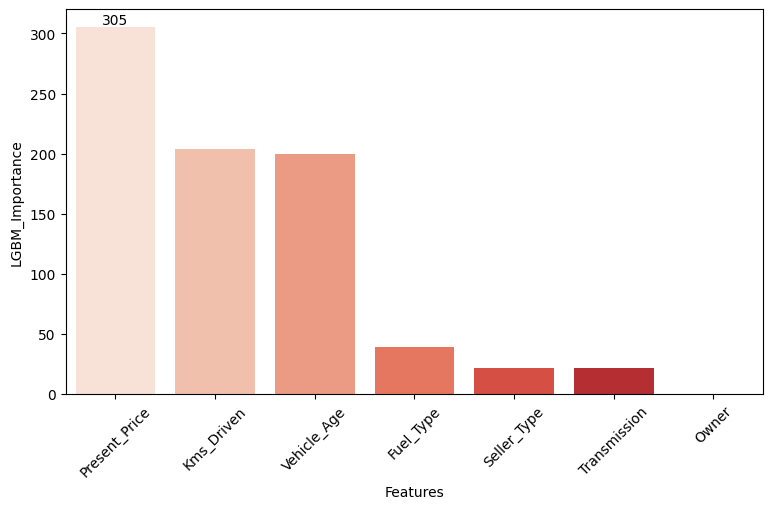

In [142]:
ax = sns.barplot(data=lgbm_imp_feats, x=lgbm_imp_feats.index, y='LGBM_Importance', palette='Reds')
ax.bar_label(ax.containers[0],fmt="%.0f")

plt.xticks(rotation=45)
plt.xlabel("Features");

<p style="background-color:firebrick;font-family:newtimeroman;font-size:200%;color:white;text-align:center;border-radius:60px 20px;"><b>THANK YOU!</b></p>